This example is inspired from :\
[WBJ21] Zheming Wang, Guillaume O. Berger, Raphaël M. Jungers. Data-driven control of switched linear systems with probabilistic stability guarantees, 2021. (url: https://arxiv.org/abs/2103.10823)

It is fully described in Chapter 6: \
"We will consider a classical Resistance-Capacitance model that allows to model heat exchange between multiple zones in a building, with the presence of an air conditioning device. Some zone have doors, that can be arbitrarily opened and closed. We will assume that the temperature is controlled via the air conditoning device (via a model-based LQR controller, see Appendix A) to quickly reach a target temperature."

In [2]:
include(joinpath(@__DIR__, "../../src/DataDrivenCSLS.jl"))
using Main.DataDrivenCSLS

We define all known constants for the considered problem, they are defined in Table 6.1

In [13]:
CtoK(C) = C + 273.15
KtoC(K) = K - 273.15

dim = 3; dim_in = 3
c = 1375
cp = 1.012
R12 = 1.5
Ro12 = 3
Ro3 = 2.7
tau = 3 * 60
m = 0.14
T_target = CtoK(24)
Ts = CtoK(16)
To = CtoK(32)
q = [.1, .1, .12]
T_0 = CtoK.([38, 34, 32])
nothing

We define $\tilde{\mathbf{\Sigma}}$ as in Equation (6.9), where each matrix corresponds to a configuration of open/closed doors between zones.

In [6]:
Σ_basis = []
for R13 in [1.2 0.8]
    for R23 in [1.2 0.8]
        A = [
            1-tau/c*(1/R12+1/R13+1/Ro12)    tau/c/R12                       tau/c/R13;
            tau/c/R12                       1-tau/c*(1/R12+1/R23+1/Ro12)    tau/c/R23;
            tau/c/R13                       tau/c/R23                       1-tau/c*(1/R13+1/R23+1/Ro3)
        ]
        push!(Σ_basis, A)
    end
end

B = tau / c * Matrix(I, dim_in, dim_in)
nothing

We compute a white-box LQR controller as explained in Appendix A.

In [7]:
Q = Matrix(I, dim, dim)
R = 0.02 * Matrix(I, dim_in, dim_in)
K, P = white_box_LQR(Σ_basis, B, Q, R)

# 1 and 2 don't work
K0 = copy(K)
K0[:, 1] .= 0
K0[:, 2] .= 0
# 1 works, 2 doesn't work
K1 = copy(K)
K1[:, 2] .= 0
# 1 doesn't work, 2 works
K2 = copy(K)
K2[:, 1] .= 0
nothing

In [8]:
# utils functions to define G

function charac_to_idx(charac)
    if charac[1] && charac[2]
        return 1
    elseif charac[2]
        return 2
    elseif charac[1]
        return 3
    end
    return 4
end

function maps_to_σ(failed, closed)
    row_idx = charac_to_idx(failed)
    col_idx = charac_to_idx(closed)
    4 * (row_idx - 1) + col_idx 
end

maps_to_σ (generic function with 1 method)

We now introduce the failures (see Chapter 6 for a full explanation): \
"Suppose that the measures for the two offices can fail, and may measure the temperature as if it had already reached the right temperature, i.e. $x_i(t) = 0$."

In [9]:
# Case where there are no fails
Σ_non_fail = []
for i = 1:size(Σ_basis)[1]
    push!(Σ_non_fail, copy(Σ_basis[i]) + B * K)
end

# Sigma when it can fail: 16 matrices in total
Σ_fail = []
for Kσ in [K0, K1, K2, K]
    for i = 1:size(Σ_basis)[1]
        push!(Σ_fail, copy(Σ_basis[i]) + B * Kσ)
    end
end

We also introduce the constraints on the failures (see Chapter 6 for a full explanation): \
"Suppose that each time that the door of an office is open, its AC controller fails, but with a time latency of $\tau$, which is one time step in the discretized model. For example, suppose that both doors are closed for some $k$, both controller work fine. At time $k + 1$, the first door opens, the first AC controller still works since it has a latency of one time step. At time $k + 2$, the doors are opened arbitrarily, but it is guaranteed that the first controller does not work."

This can be modelled by the following automaton $\mathbf{G}$ (as depicted in Figure 6.3):

In [10]:
G = LightAutomaton(4)

add_transition!(G, 1, 1, maps_to_σ([false, false], [true, true]))
add_transition!(G, 1, 2, maps_to_σ([false, false], [false, true]))
add_transition!(G, 1, 3, maps_to_σ([false, false], [true, false]))
add_transition!(G, 1, 4, maps_to_σ([false, false], [false, false]))

add_transition!(G, 2, 1, maps_to_σ([true, false], [true, true]))
add_transition!(G, 2, 2, maps_to_σ([true, false], [false, true]))
add_transition!(G, 2, 3, maps_to_σ([true, false], [true, false]))
add_transition!(G, 2, 4, maps_to_σ([true, false], [false, false]))

add_transition!(G, 3, 1, maps_to_σ([true, true], [true, true]))
add_transition!(G, 3, 2, maps_to_σ([true, true], [false, true]))
add_transition!(G, 3, 3, maps_to_σ([true, true], [true, false]))
add_transition!(G, 3, 4, maps_to_σ([true, true], [false, false]))

add_transition!(G, 4, 1, maps_to_σ([false, true], [true, true]))
add_transition!(G, 4, 2, maps_to_σ([false, true], [false, true]))
add_transition!(G, 4, 3, maps_to_σ([false, true], [true, false]))
add_transition!(G, 4, 4, maps_to_σ([false, true], [false, false]))

HybridSystems.LightTransition{LightGraphs.SimpleGraphs.SimpleEdge{Int64}}(Edge 4 => 4, 16)

We now simulate the dynamical system for three different configurations:
* There is no controller
* There is a non-failing controller
* There is a failing controller

Figure 6.4 can be recovered by executing the cell below

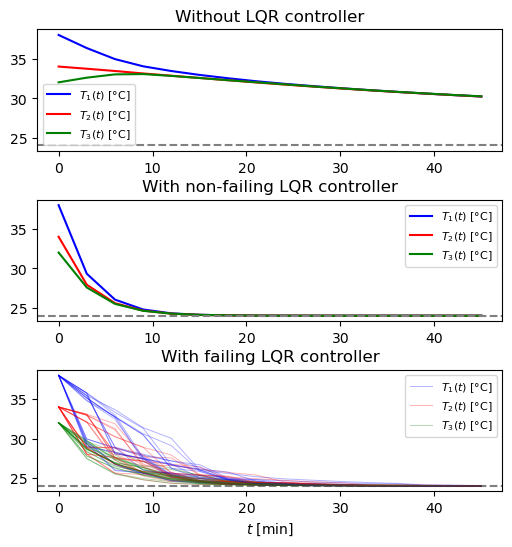

In [16]:
N_MIN = 45 # to change if other total time

total_time = N_MIN * 60
time_range = (0:tau:total_time) ./ 60

n_steps = size(time_range)[1] - 1

ind_term = tau / c * (q .+ (m * cp * Ts) + (To ./ [Ro12, Ro12, Ro3]))

Σ_simul = []
for i = 1:size(Σ_basis)[1]
    push!(Σ_simul, copy(Σ_basis[i]))
    for j = 1:3
        Σ_simul[i][j, j] -= tau / c * m * cp
    end
end

using PyPlot
colors = ["blue", "red", "green"]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))
ax1.set_title("Without LQR controller")
ax2.set_title("With non-failing LQR controller")
ax3.set_title("With failing LQR controller")

_, _, Tx, Ty = generate_trajectories(Σ_simul, nothing, 1, n_steps; x0 = T_0, ind_term = ind_term)
_, _, x_controlled_nf, y_controlled_nf = generate_trajectories(Σ_non_fail, nothing, 1, n_steps; x0 = T_0 .- T_target)

for zone = 1:dim
    to_plot = reshape(Ty[zone, :, 1], (n_steps))
    to_plot_controlled_nf = reshape(y_controlled_nf[zone, :, 1], (n_steps)) .+ T_target
    pushfirst!(to_plot, Tx[zone, 1])
    pushfirst!(to_plot_controlled_nf, x_controlled_nf[zone, 1] .+ T_target)
    ax1.plot(time_range, KtoC.(to_plot), linestyle="-", color=colors[zone], label="\$T_{$(zone)}(t)\$ [°C]")
    ax2.plot(time_range, KtoC.(to_plot_controlled_nf), linestyle="-", color=colors[zone], label="\$T_{$(zone)}(t)\$ [°C]")
end
for ax in [ax1, ax2]
    ax.legend(fontsize=8)
    ax.axhline(KtoC(T_target), linestyle="--", color="grey")
end

N_simul = 20
for i =1:N_simul
    _, _, x_controlled_f, y_controlled_f = generate_trajectories(Σ_fail, G, 1, n_steps; x0 = T_0 .- T_target)
    for zone = 1:dim
        to_plot_controlled_f = reshape(y_controlled_f[zone, :, 1], (n_steps)) .+ T_target
        pushfirst!(to_plot_controlled_f, x_controlled_f[zone, 1] .+ T_target)
        ax3.plot(time_range, KtoC.(to_plot_controlled_f), linestyle="-", linewidth = 0.7, alpha=0.3, color=colors[zone], label="\$T_{$(zone)}(t)\$ [°C]")
    end
    if i == 1 ax3.legend(fontsize=8); ax3.axhline(KtoC(T_target), linestyle="--", color="grey") end
end

ax3.set_xlabel("\$t\$ [min]")
subplots_adjust(hspace=0.4)
savefig("t$(N_MIN).pdf")

We can now compute the bounds for a sample of 50 000 trajectories with the CQLF and MQLF methods, and we recover the values in Table 6.2

In [ ]:
N = 50000

V = nstates(G)
m = 16
β = .99
β1 = (1 + β) / 2.
β2 = β1

# MQLF
u, v, x, y = generate_trajectories(Σ_fail, G, N, 1)
y = reshape(y, size(x))
lb_MQLF, ub_MQLF = bounds_MQLF(x, u, y, v, V, β1, β2, m)

# CQLF
l = 1
p_lmin = 1 / 16
quantity = 1 / p_lmin
ub_CQLF = upper_bound_CQLF(x, y, β, l, quantity; quantity_max = quantity)

f = open("res.txt", "a")
println(f, "N = $N: MQLF says CJSR in [$lb_MQLF, $ub_MQLF], CQLF says CJSR <= $ub_CQLF")
close(f)

nothing